# Parsing Information about Top 100 "Best Value" U.S. Private Universities from Kiplinger

Write a webpage crawler for extracting information

In [1]:
import requests
from lxml import html

# fetch page url
url = "http://www.kiplinger.com/tool/college/T014-S001-kiplinger-s-best-values-in-private-colleges/"
response = requests.get(url) # get the html
doc = html.fromstring(response.text) # parse it and create a document

In [2]:
# extract data from text
colleges = doc.xpath('//tr[@onmouseover="this.className=\'all hover\'"]')

# testing
# text = [event.text_content() for event in calendar]
# text

In [3]:
# parse data on colleges
def parseColleges(uni):
    rank = uni.xpath(".//td")[0].text_content()
    name = uni.xpath(".//td/a")[0].text_content().split(",")[0]
    state = uni.xpath(".//td")[2].text_content()
    admit = uni.xpath(".//td")[3].text_content().strip("%")
    grad = uni.xpath(".//td")[4].text_content().strip("%")
    costTemp = uni.xpath(".//td")[5].text_content().strip("$").strip("§")
    cost = costTemp.split(",")[0] + costTemp.split(",")[1]
    debtTemp = uni.xpath(".//td")[9].text_content().strip("$")
    debt = (debtTemp.split(",")[0] + debtTemp.split(",")[1])
    #title = event.xpath(".//td[contains(@onclick,'document.location=')]/span")[0].text_content()
    #title = event.xpath(".//td")[2].text_content()
    
    result = {
        "Rank": int(rank),
        "Name" : name,
        "State" : state,
        "AdmitRate" : float(admit)/100,
        "GraduationRate" : float(grad)/100,
        "TotalCost" : float(cost),
        "AvgDebt" : float(debt)
    }
    return result

# store data in a dictionary
data = [parseColleges(uni) for uni in colleges]

[{'AdmitRate': 0.07,
  'AvgDebt': 8577.0,
  'GraduationRate': 0.9,
  'Name': 'Princeton University',
  'Rank': 1,
  'State': 'NJ',
  'TotalCost': 61140.0},
 {'AdmitRate': 0.11,
  'AvgDebt': 19104.0,
  'GraduationRate': 0.86,
  'Name': 'Duke University',
  'Rank': 2,
  'State': 'NC',
  'TotalCost': 66963.0},
 {'AdmitRate': 0.06,
  'AvgDebt': 16723.0,
  'GraduationRate': 0.86,
  'Name': 'Harvard University',
  'Rank': 3,
  'State': 'MA',
  'TotalCost': 64565.0},
 {'AdmitRate': 0.12,
  'AvgDebt': 21506.0,
  'GraduationRate': 0.87,
  'Name': 'Vanderbilt University',
  'Rank': 4,
  'State': 'TN',
  'TotalCost': 62598.0},
 {'AdmitRate': 0.07,
  'AvgDebt': 15521.0,
  'GraduationRate': 0.88,
  'Name': 'Yale University',
  'Rank': 5,
  'State': 'CT',
  'TotalCost': 68230.0},
 {'AdmitRate': 0.16,
  'AvgDebt': 25528.0,
  'GraduationRate': 0.81,
  'Name': 'Rice University',
  'Rank': 6,
  'State': 'TX',
  'TotalCost': 58448.0},
 {'AdmitRate': 0.09,
  'AvgDebt': 20677.0,
  'GraduationRate': 0.85,
 

Store retrieved information in MySQL database

In [4]:
import MySQLdb as mdb
import sys

# connect to MySQL database
def connectDatabase():
    con = mdb.connect(host = '34.199.88.98', # my EC2 instance IP address
                      user = 'root', 
                      passwd = 'dwdstudent2015', 
                      charset = 'utf8', use_unicode=True);
    return con

In [5]:
# set up a database to store the data in
def createUniDatabase(con, db_name):
    ''' 
    Connects to the database and creates (if it does not exist)
    the database and the table to store the data
    '''
    # query to create a database in SQL
    create_db_query = "CREATE DATABASE IF NOT EXISTS {0} DEFAULT CHARACTER SET 'utf8'".format(db_name)

    cursor = con.cursor()
    cursor.execute(create_db_query)
    cursor.close()
    pass

In [6]:
# set up table in database
def createUniTable(con, db_name, table_name):
    cursor = con.cursor()
    # create a table using CREATE TABLE
    # {0} and {1} are placeholders for the parameters in the format() statement
    create_table_query = '''CREATE TABLE IF NOT EXISTS {0}.{1} 
                                    (Rank int,
                                    Name varchar(100),
                                    State varchar(5),
                                    AdmitRate float, 
                                    GraduationRate float,
                                    TotalCost float,
                                    AvgDebt float,
                                    PRIMARY KEY(Name)
                                    )'''.format(db_name, table_name)
    cursor.execute(create_table_query)
    cursor.close()

In [7]:
con = connectDatabase()
db_name = 'TopPrivateColleges'
createUniDatabase(con, db_name)
universities = 'Colleges'
createUniTable(con, db_name, universities)

In [8]:
# store calendar data into table in the database
def storeUniData(con, data):
    '''
    Accepts as a parameter a list of dictionaries (data), where
    each dictionary is a college from the Kiplinger list.
    Check if the college exists in the database already.
    If it does not, store it in the database.
    '''
    db_name = 'TopPrivateColleges'
    table_name = 'Colleges'
    
    for uni in data:
        rank = uni["Rank"]
        name = uni["Name"]
        state = uni["State"]
        admit = uni["AdmitRate"]
        grad = uni["GraduationRate"]
        cost = uni["TotalCost"]
        debt = uni["AvgDebt"]
        insertUniInfo(con, db_name, table_name, 
                      rank, name, state, admit, grad, cost, debt)
    
    # writes the data into the database
    con.commit()
    return

In [9]:
# use INSERT command
def insertUniInfo(con, db_name, table_name, 
                  rank, name, state, admit, grad, cost, debt):
    query_template = '''INSERT IGNORE INTO {0}.{1}
                                    (Rank,
                                    Name,
                                    State,
                                    AdmitRate, 
                                    GraduationRate,
                                    TotalCost,
                                    AvgDebt) 
                VALUES (%s, %s, %s, %s, %s, %s, %s)'''.format(db_name, table_name)

    cursor = con.cursor()
    query_parameters = (rank, name, state, admit, grad, cost, debt)
    cursor.execute(query_template, query_parameters)
    cursor.close()


storeUniData(con, data)

Read the stored information from the MySQL database, load the data into a Pandas dataframe, and generate a plot.

In [42]:
%matplotlib inline

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# retrieve information from MySQL database 
# and convert result to pandas dataframe
sql_query = ('''SELECT * FROM TopPrivateColleges.Colleges 
             ORDER BY Rank ASC;''')
df = pd.read_sql(sql_query, con)
df

,Rank,Name,State,AdmitRate,GraduationRate,TotalCost,AvgDebt
0,1,Princeton University,NJ,0.07,0.90,61140.0,8577.0
1,2,Duke University,NC,0.11,0.86,66963.0,19104.0
2,3,Harvard University,MA,0.06,0.86,64565.0,16723.0
3,4,Vanderbilt University,TN,0.12,0.87,62598.0,21506.0
4,5,Yale University,CT,0.07,0.88,68230.0,15521.0
5,6,Rice University,TX,0.16,0.81,58448.0,25528.0
6,7,California Institute of Technology,CA,0.09,0.85,63000.0,20677.0
7,8,Stanford University,CA,0.05,0.75,63996.0,21238.0
8,9,Brown University,RI,0.09,0.83,66106.0,22197.0
9,10,Massachusetts Institute of Technology,MA,0.08,0.82,63662.0,23485.0


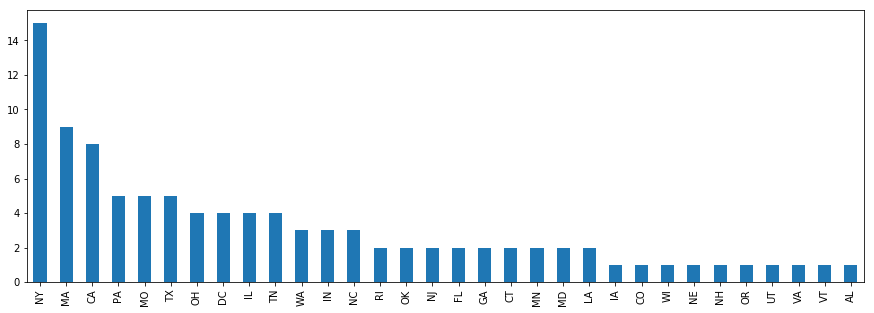

In [47]:
# generate a plot
df['State'] = pd.Categorical(df['State'])
plt.rcParams['figure.figsize'] = (15, 5) # make the graph bigger
df['State'].value_counts().plot(kind='bar')

# This is a bar graph that depicts how many top 10 
# colleges are found in each of the 50 states